# Modelling

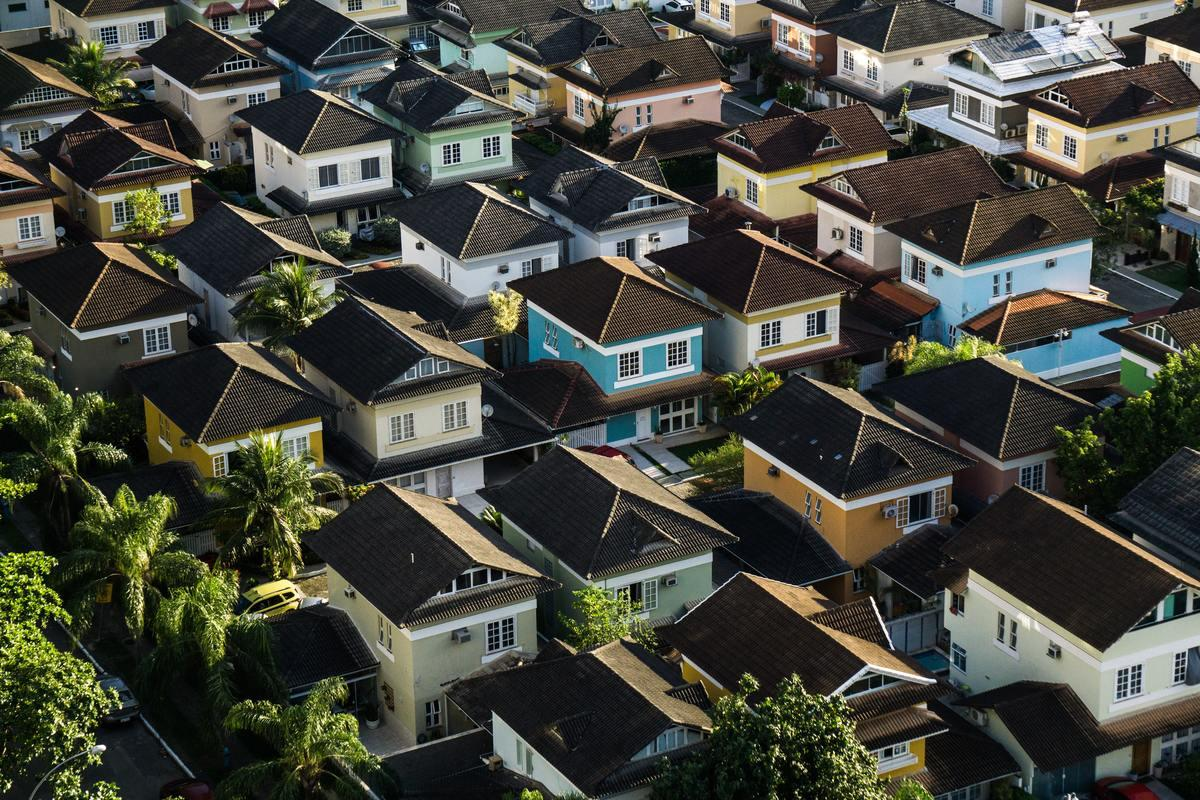

In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import statsmodels.api as sm
import folium

from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import CooksDistance

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [159]:
# Open the csv from the data cleaning notebook
df = pd.read_csv('data/cleaned_data.csv', index_col=0)

merged_king_data = df.copy()
merged_king_data['grade'] = merged_king_data['grade'].astype(object) #cchange the datatype of "grade" into object to be able to OHE it later

In [160]:
merged_king_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20228 entries, 0 to 20227
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  20228 non-null  float64
 1   bedrooms               20228 non-null  int64  
 2   bathrooms              20228 non-null  float64
 3   sqft_living            20228 non-null  int64  
 4   sqft_lot               20228 non-null  int64  
 5   floors                 20228 non-null  float64
 6   view                   20228 non-null  object 
 7   condition              20228 non-null  object 
 8   grade                  20228 non-null  object 
 9   sqft_above             20228 non-null  int64  
 10  yr_built               20228 non-null  int64  
 11  zipcode                20228 non-null  int64  
 12  sqft_living15          20228 non-null  int64  
 13  sqft_lot15             20228 non-null  int64  
 14  city                   20228 non-null  object 
 15  ba

## Functions for our Analysis

In [161]:
# VIF dataframe
def cal_vif(X):
    """
    Variance inflation factor, VIF, for one exogenous variable

    The variance inflation factor is a measure for multicollinearity.

    One recommendation is that if VIF is greater than 10, then the explanatory variable is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

    Parameters
    X{ndarray, DataFrame}

    Returns
    DataFrame
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

In [162]:
def summary_model(model, X, y):
    """
    Summarize the Regression Results.

    Parameters
    model
    Fitted scikitlearn linear model.  
    
    X
    Names for the exogenous variables. Must match the number of parameters in the model.
    
    y
    Name of endogenous (response) variable.

    Returns
    Summary

    """
    
    result = (
        print(f'R-squared: {model.score(X,y)} \nIntercept: {model.intercept_} \nCoefficient: {model.coef_}')
    )
    return result

In [196]:
def error_scores(predictions, y, test=True):
    """
    Summarize R-squared, Mean Absolute Error, Mean Squared Errors and Root Mean Squared Errors.

    Parameters
    predictions
    Predictions from the model.  
    
    y
    Name of endogenous (response) variable.
    
    test: bool
    default True
    False for train

    Returns
    Print the error scores

    """
    
    if test==True:
        print("Testing Metrics:")
    else:
        print("Training Metrics:")
    # R2
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error in $: {mean_squared_error(np.exp(y_train), np.exp(train_preds), squared=False)}")

### Data Engineering and transformation

We log transform the target variable "Price" to normalize distribution for "Price" from a skewed distribution. 

In [164]:
merged_king_data['price'] = np.log(merged_king_data['price'])

We re-engineer the bathrooms and bedrooms feature into one called "bathrooms per bedrooms" as we feel this ratio should be easier to understand. 

In [165]:
merged_king_data['bathrooms_per_bedroom'] = merged_king_data['bathrooms'] / merged_king_data['bedrooms']
merged_king_data = merged_king_data.drop(columns=['bathrooms', 'bedrooms'], axis=1)

In [166]:
merged_king_data.head()

,price,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,city,bathrooms_per_bedroom
0,2.516760,1220,8075,1.0,NONE,Fair,7,890,1969,98001,1290,7800,Auburn,0.250000
1,2.531093,2240,4648,2.0,NONE,Average,7,2240,2005,98001,2221,4557,Auburn,0.625000
2,2.568772,2714,17936,2.0,NONE,Average,9,2714,2005,98001,2590,18386,Auburn,0.833333
3,2.548965,2160,9528,2.0,NONE,Average,9,2160,1992,98001,2280,9937,Auburn,0.625000
4,2.513319,1450,11204,1.0,NONE,Average,7,1450,2003,98001,1520,9518,Auburn,0.666667


We have our cleaned and munged data however, we still have to transform the categorical variables. We use OneHotEncoder to do that however, we fit the transformer after splitting the data into a training and testing sets.

We start with the train-test split with test size of 25% and random state 42. We have three categorical variables 
- View
- Condition
- City

In [167]:
X = merged_king_data.drop(columns='price')
y = merged_king_data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

cat_cols = [c for c in merged_king_data if merged_king_data[c].dtype == 'O']
cat_cols

X_train.describe(include=['O'])

,view,condition,grade,city
count,15171,15171,15171,15171
unique,5,5,10,22
top,NONE,Average,7,Seattle
freq,13647,9852,6319,6750


Now, we can fit the OneHotEncoder for the categorical variables on the training set and transform it on both the training and testing sets.

In [168]:
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first', 
                        categories='auto')

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [169]:
X_train_enc = pd.DataFrame(X_train_enc.todense(), columns= ct.get_feature_names(), index = X_train.index) ##emoved X_train_enc.todense()
X_train_enc


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x0_NONE,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_5,ohe__x2_6,...,ohe__x3_Vashon,sqft_living,sqft_lot,floors,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,bathrooms_per_bedroom
5900,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3340.0,24755.0,2.0,3340.0,2002.0,98038.0,3420.0,23274.0,0.500000
20195,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1650.0,5102.0,1.0,1300.0,1953.0,98199.0,1440.0,5102.0,0.333333
991,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2230.0,13529.0,1.0,2230.0,1949.0,98004.0,2230.0,11900.0,0.583333
2447,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1640.0,7194.0,1.5,1480.0,1915.0,98011.0,1440.0,9405.0,0.437500
1887,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1420.0,11040.0,1.0,1420.0,1961.0,98007.0,1530.0,8208.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1800.0,4180.0,2.0,1800.0,1921.0,98102.0,2180.0,4620.0,0.437500
11964,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,820.0,681.0,3.0,820.0,2006.0,98103.0,820.0,1156.0,0.500000
5390,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2390.0,6435.0,1.0,1600.0,1978.0,98034.0,2020.0,7300.0,0.833333
860,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4220.0,26784.0,1.0,2110.0,1958.0,98004.0,3450.0,33945.0,0.700000


In [170]:
X_test_enc = pd.DataFrame(X_test_enc.todense(), columns= ct.get_feature_names(), index = X_test.index) #removed X_test_enc.todense()
X_test_enc

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x0_NONE,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_5,ohe__x2_6,...,ohe__x3_Vashon,sqft_living,sqft_lot,floors,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,bathrooms_per_bedroom
15378,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1500.0,1375.0,2.0,1200.0,2014.0,98119.0,1680.0,1627.0,0.833333
12124,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,3110.0,4400.0,1.5,2010.0,1914.0,98105.0,1240.0,4280.0,0.392857
13734,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1460.0,5700.0,1.5,1460.0,1912.0,98115.0,1780.0,3800.0,0.750000
2043,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1460.0,7860.0,1.0,1460.0,1967.0,98008.0,1850.0,8148.0,0.666667
16675,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1020.0,10200.0,1.0,1020.0,1954.0,98133.0,1170.0,8188.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1690.0,10062.0,1.0,940.0,1928.0,98178.0,2390.0,6650.0,0.666667
17665,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1460.0,1296.0,2.0,1160.0,2008.0,98144.0,1460.0,1296.0,1.250000
17892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1210.0,10185.0,1.0,1210.0,1957.0,98146.0,1320.0,10245.0,0.333333
12802,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1780.0,2493.0,3.0,1780.0,1981.0,98107.0,2050.0,4400.0,1.250000


### Dummy Model

We create a Dummy Model using the Dummy Regressor which is a kind of Regressor that gives prediction based on simple strategies without paying any attention to the input Data.

In [171]:
# Instantiate
dummy_lr = DummyRegressor()

In [172]:
dummy_lr.fit(X,y)

DummyRegressor()

In [173]:
# score - this is like a benchmark score for our model we build from here.
dummy_lr.score(X,y)

0.0

We start with building a simple regression model with the feature which is most highly correlated with our target "Price"

### Correlation Heatmap to Build a Simple Regression Model

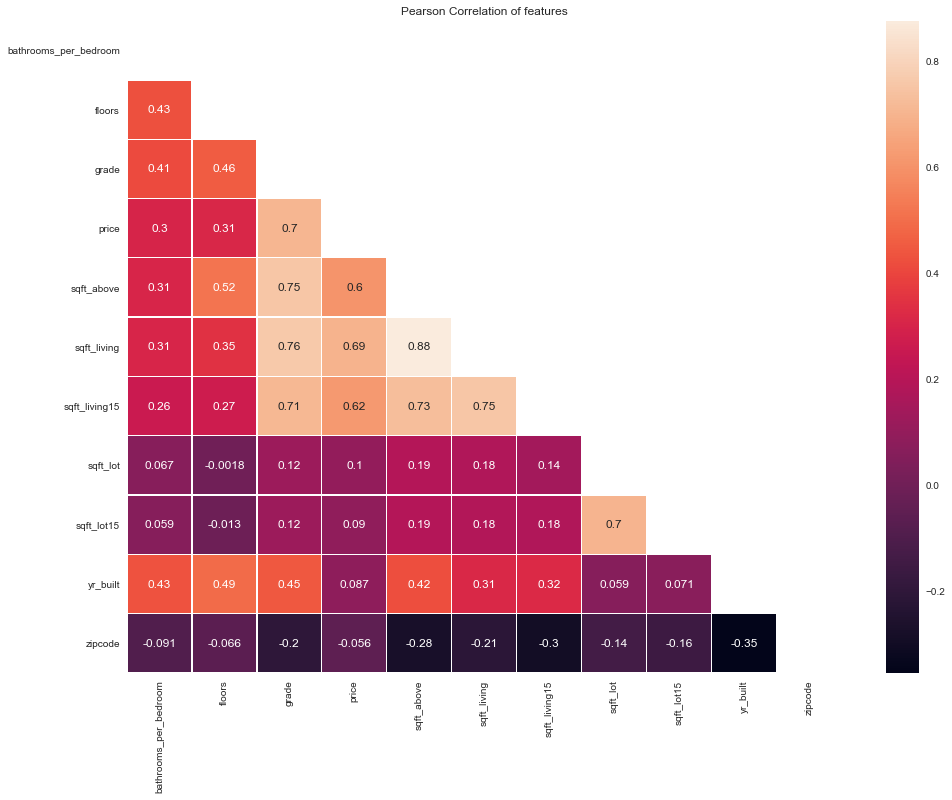

In [174]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in merged_king_data.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = merged_king_data.columns.difference(str_list) 
# Create Dataframe containing only numerical features
merged_king_data_num = merged_king_data[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(merged_king_data_num.astype(float).corr(),linewidths=0.25, annot=True, mask=np.triu(np.ones_like(num_list, dtype=bool)));


In [175]:
# assign price to the variable target_feature
#note price is log transformed already.
target_feature = 'price'

We see from the heatmap above that "sqft_living" is most highly correlated with "price" so we use it in our simple regression model.

In [176]:
# assign sqft_living to the variable most_correlated_feature to make a simple regression model.
most_correlated_feature = 'sqft_living'

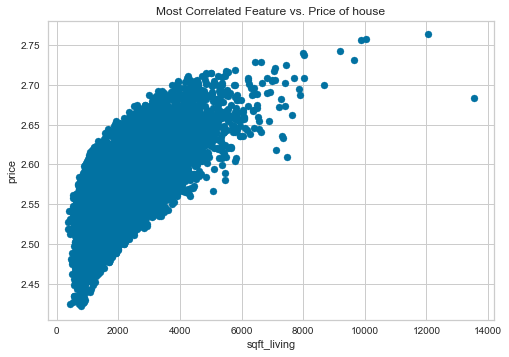

In [177]:
# plot a scatter plot to visulaize most correlated feature and target variable 
fig, ax = plt.subplots()

ax.scatter(x=merged_king_data[most_correlated_feature], y=merged_king_data[target_feature])
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel(target_feature)
ax.set_title("Most Correlated Feature vs. Price of house");

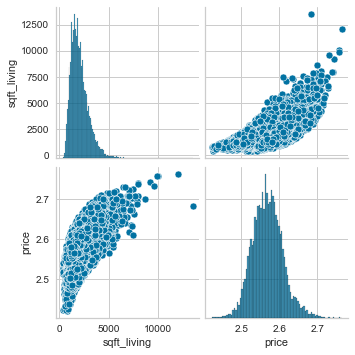

In [178]:
# see the distribution of the feature and target
slr_df = merged_king_data[['sqft_living', 'price']]
sns.pairplot(slr_df);

We identified sqft_living as the most correlated feature, we have a scatter plot that shows a fairly clear linear relationship between that feature and the target (log of price).

In [179]:
# make simple regression model
keep_cols = ['sqft_living']
X_train_sm = X_train_enc[keep_cols]

In [180]:
simple_mdl = LinearRegression()

In [181]:
simple_mdl.fit(X_train_sm, y_train)

LinearRegression()

In [182]:
summary_model(simple_mdl, X_train_sm, y_train)

R-squared: 0.4764138343563109 
Intercept: 2.506799519967085 
Coefficient: [2.99422937e-05]


### Multiple Regression Models

#### Model 1 - Includes all features

In [183]:
X_train_enc.columns

Index(['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD', 'ohe__x0_NONE',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_7', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City',
       'ohe__x3_Federal Way', 'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon',
       'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'yr_built',
       'zipcode', 'sqft_living15', 'sqft_lot15', 'bathrooms_per_bedroom'],
      dtype='object')

In [184]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD', 'ohe__x0_NONE',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_7', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City',
       'ohe__x3_Federal Way', 'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon',
       'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'yr_built',
       'zipcode', 'sqft_living15', 'sqft_lot15', 'bathrooms_per_bedroom']
X_train1 = X_train_enc[keep_cols]

In [185]:
model1 = LinearRegression()

model1.fit(X_train1, y_train)

LinearRegression()

In [186]:
summary_model(model1, X_train1, y_train)

R-squared: 0.7927382120402392 
Intercept: 35.14200007688801 
Coefficient: [ 2.04356342e-02  1.43116183e-03  3.18500480e-03 -7.18422795e-03
 -1.31398949e-02  3.47776115e-03 -1.45135703e-02  8.32377251e-03
  4.98853490e-03  1.59751333e-02  3.40262284e-02  4.57213421e-02
  5.64296718e-02  6.12106899e-02  6.25938460e-02  5.85925435e-02
  6.37917615e-02  5.37855219e-02  2.43233770e-02  3.51678461e-02
  3.07764822e-02  3.23518057e-02  4.07254962e-02  1.91945574e-03
  4.71316779e-02  3.91457594e-02  1.58513206e-02  5.82965399e-02
  2.56810801e-02  9.75808659e-02  7.17457171e-02  4.09112500e-02
  6.07953957e-02  3.65971737e-02  6.15856165e-02  8.34945006e-02
  5.08164800e-02  5.39614135e-02  1.18824451e-05  4.08338432e-08
  3.28501681e-03  2.90238473e-06 -2.22547147e-04 -3.29187808e-04
  7.83440730e-06 -3.01816944e-08  1.05820245e-02]


In [187]:
cal_vif(X_train_enc)

,feature,VIF
0,ohe__x0_EXCELLENT,1.395324
1,ohe__x0_FAIR,1.392715
2,ohe__x0_GOOD,1.571957
3,ohe__x0_NONE,23.163658
4,ohe__x1_Fair,1.034410
5,ohe__x1_Good,1.729492
6,ohe__x1_Poor,1.025108
7,ohe__x1_Very Good,1.287868
8,ohe__x2_5,9.141106
9,ohe__x2_6,67.368613


#### Model 2
Excluding the following predictors of the model as they have a high VIF indicating high multicollinearity. 
- yr_built
- zipcode
- ohe__x2_7


In [188]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD', 'ohe__x0_NONE',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City',
       'ohe__x3_Federal Way', 'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon',
       'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'bathrooms_per_bedroom']

X_train2 = X_train_enc[keep_cols]
model2 = LinearRegression()

model2.fit(X_train2, y_train)

LinearRegression()

In [189]:
summary_model(model2, X_train2, y_train)

R-squared: 0.7506915828135485 
Intercept: 2.4783808760999477 
Coefficient: [ 1.99662457e-02  5.45705214e-04  2.58357709e-03 -7.16264252e-03
 -1.10077632e-02  6.71053725e-03 -8.67994592e-03  1.40641247e-02
 -2.42079767e-02 -1.60943381e-02  1.02966876e-02  2.02672359e-02
  2.53182512e-02  2.72570383e-02  2.28382953e-02  2.92849142e-02
  5.43283007e-02  2.06838204e-02  3.29907581e-02  2.65184890e-02
  2.59645155e-02  3.56456790e-02 -2.10731052e-03  3.80318353e-02
  3.16800081e-02  2.94201729e-03  4.86988010e-02  1.19239038e-02
  8.92325378e-02  6.16738245e-02  2.65815756e-02  4.40489672e-02
  1.80453088e-02  3.81086435e-02  4.49762660e-02  2.86786817e-02
  3.32961667e-02  1.27363517e-05  4.92004218e-08  3.39603479e-03
  1.41253904e-06  7.60621795e-06 -4.10096833e-08  4.72668415e-03]


In [190]:
cal_vif(X_train2)

,feature,VIF
0,ohe__x0_EXCELLENT,1.339606
1,ohe__x0_FAIR,1.309179
2,ohe__x0_GOOD,1.470584
3,ohe__x0_NONE,16.241457
4,ohe__x1_Fair,1.029048
5,ohe__x1_Good,1.566055
6,ohe__x1_Poor,1.023915
7,ohe__x1_Very Good,1.194349
8,ohe__x2_5,1.067827
9,ohe__x2_6,1.299040


#### Model 3
Excluding the following predictors of the model as they have a high VIF indicating high multicollinearity. 
- ohe__x0_NONE
- floors
- sqft_above
- sqft_living15
- sqft_lot15

In [191]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City',
       'ohe__x3_Federal Way', 'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon', 'sqft_living', 'sqft_lot', 'bathrooms_per_bedroom']
X_train3 = X_train_enc[keep_cols]
X_test3= X_test_enc[keep_cols]
model3 = LinearRegression()

model3.fit(X_train3, y_train)

LinearRegression()

In [192]:
summary_model(model3, X_train3, y_train)

R-squared: 0.7418872461426873 
Intercept: 2.4837323470282513 
Coefficient: [ 2.71699250e-02  8.11221888e-03  1.01087474e-02 -1.13644603e-02
  5.97010830e-03 -7.10320464e-03  1.30862518e-02 -2.52411923e-02
 -1.71769757e-02  1.30313172e-02  2.58501088e-02  3.22853965e-02
  3.60920794e-02  3.21297519e-02  3.30921793e-02  5.53220539e-02
  2.07698285e-02  3.44565370e-02  2.55325778e-02  2.75621437e-02
  3.61863658e-02 -2.13210690e-03  3.92069487e-02  3.24791253e-02
  3.68382676e-03  4.89914863e-02  1.39934719e-02  9.06024426e-02
  6.37583264e-02  2.70366787e-02  4.55064788e-02  1.89188671e-02
  4.07692820e-02  4.43928628e-02  3.30130014e-02  3.25205293e-02
  1.64194921e-05  2.56158194e-08  5.76052123e-03]


In [193]:
cal_vif(X_train3)

,feature,VIF
0,ohe__x0_EXCELLENT,1.088877
1,ohe__x0_FAIR,1.037608
2,ohe__x0_GOOD,1.087106
3,ohe__x1_Fair,1.027826
4,ohe__x1_Good,1.520616
5,ohe__x1_Poor,1.023146
6,ohe__x1_Very Good,1.174690
7,ohe__x2_5,1.062997
8,ohe__x2_6,1.273552
9,ohe__x2_8,2.056109


From the VIF's of the features included in Model 3, we see that we hvae addressed the issue of multicollinearity to a great extent. We have only 3 predictors with a VIF score more than 5. Namely, Sqft_ living, bathrooms_per_bedrooms and Seattle city. We decided not to drop these variables as they are infact important variables intutively to predict house prices in King County. 

#### Now, lets take a look at the Errors for Model 3:

In [194]:
# Grab training set predictions
train_preds = model3.predict(X_train3)

# And test set predictions
test_preds = model3.predict(X_test3)

In [195]:
error_scores(train_preds, y_train, test=False)

Training Metrics:
R2: 0.742
Mean Absolute Error: 0.015
Mean Squared Error: 0.000
Root Mean Squared Error: 0.020
Root Mean Squared Error in $: 0.2655157730364835


In [197]:
error_scores(test_preds, y_train, test=True)

Testing Metrics:
R2: 0.742
Mean Absolute Error: 0.015
Mean Squared Error: 0.000
Root Mean Squared Error: 0.020
Root Mean Squared Error in $: 0.2655157730364835


#### Now, we start look at errors distributions for Model 3 to check for Heteroscedasticity and Autocorrelation.

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


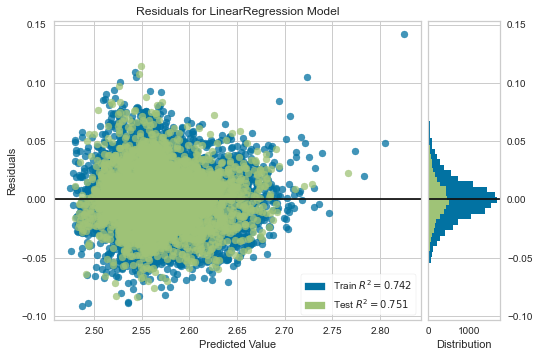

In [199]:
visualizer = ResidualsPlot(model3)

visualizer.fit(X_train3, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

The graphs plots the error terms and shows that the error asuumptions are not violated. Meaning the errors are distributed normally. The error terms do not show a pattern i.e. they are homogeneous.

#### Check Autocorrelation

In [202]:
# Calculate the residuals from the predictions and target values from the training set
resids = train_preds - y_train

In [203]:
sm.stats.stattools.durbin_watson(resids) # YAyyyy

1.989024758984738

#### We also make the same Model as Model 3 above using Statsmodel 
This is done to access the Summary table to check for significance of the predictors (alpha = 0.05)

In [204]:
y_sm = pd.DataFrame(y_train)

In [205]:
endog = y_train
exog = X_train3
lin_reg_model = sm.OLS(endog=endog, exog=sm.add_constant(exog)).fit()

In [206]:
lin_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     1115.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:05:07   Log-Likelihood:                 37548.
No. Observations:               15171   AIC:                        -7.502e+04
Df Residuals:                   15131   BIC:                        -7.471e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.4837      0.001   1975.712      0.000       2.481       2.486
ohe__x0_EXCELLENT         0.0272      0.001     19.579      0.000       0.024       0.030
ohe__x0_FAIR              0.0081      0.001      6.246      0.000       0.006       0.011
ohe__x0_GOOD              0.0101      0.001      9.087      0.000       0.008       0.012
ohe__x1_Fair             -0.0114      0.002     -5.944      0.000      -0.015      -0.008
ohe__x1_Good              0.0060      0.000     14.752      0.000       0.005       0.007
ohe__x1_Poor             -0.0071      0.004     -1.651      0.099      -0.016       0.001
ohe__x1_Very Good         0.0131      0.001     20.648      0.000       0.012       0.014
ohe__x2_5                -0.0252      0.002    -15.860      0.000      -0.028      -0.022
ohe__x2_6                -0.0172      0.001    -27.637      0.000      -0.018      -0.016
ohe__x2_8                 0.0130      0.000     28.961      0.000       0.012       0.014
ohe__x2_9                 0.0259      0.001     38.287      0.000       0.025       0.027
ohe__x2_10                0.0323      0.001     32.976      0.000       0.030       0.034
ohe__x2_11                0.0361      0.002     23.127      0.000       0.033       0.039
ohe__x2_12                0.0321      0.003     11.190      0.000       0.027       0.038
ohe__x2_13                0.0331      0.007      4.689      0.000       0.019       0.047
ohe__x3_Bellevue          0.0553      0.001     45.909      0.000       0.053       0.058
ohe__x3_Black Diamond     0.0208      0.003      8.006      0.000       0.016       0.026
ohe__x3_Bothell           0.0345      0.002     17.513      0.000       0.031       0.038
ohe__x3_Carnation         0.0255      0.002     10.671      0.000       0.021       0.030
ohe__x3_Duvall            0.0276      0.002     13.562      0.000       0.024       0.032
ohe__x3_Fall City         0.0362      0.003     12.752      0.000       0.031       0.042
ohe__x3_Federal Way      -0.0021      0.001     -1.630      0.103      -0.005       0.000
ohe__x3_Issaquah          0.0392      0.001     29.146      0.000       0.037       0.042
ohe__x3_Kenmore           0.0325      0.002     18.616      0.000       0.029       0.036
ohe__x3_Kent              0.0037      0.001      2.936      0.003       0.001       0.006
ohe__x3_Kirkland          0.0490      0.001     39.031      0.000       0.047       0.051
ohe__x3_Maple Valley      0.0140      0.001      9.928      0.000       0.011       0.017
ohe__x3_Medina            0.0906      0.004     23.951      0.000       0.083       0.098
ohe__x3_Mercer Island     0.0638      0.002     35.629      0.000       0.060       0.067
ohe__x3_North Bend        0.0270      0.002     14.542      0.000       0.023       0.031
ohe__x3_Redmond        

#### Model 4
We exclude the following predictors as they are insigificant 
- ohe__x1_Poor
- ohe__x3_Federal Way

In [208]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City', 
        'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon', 'sqft_living', 
        'sqft_lot', 'bathrooms_per_bedroom']
X_train4 = X_train_enc[keep_cols]
X_test4=X_test_enc[keep_cols]
model4= LinearRegression()

model4.fit(X_train4, y_train)

LinearRegression()

In [209]:
summary_model(model4, X_train4, y_train)

R-squared: 0.741794749506127 
Intercept: 2.4824482845208333 
Coefficient: [ 2.71140373e-02  8.05346560e-03  1.01008218e-02 -1.13451089e-02
  5.98955584e-03  1.31386810e-02 -2.54657907e-02 -1.71967337e-02
  1.29909717e-02  2.58303425e-02  3.22424519e-02  3.60499082e-02
  3.21095045e-02  3.30536284e-02  5.65558142e-02  2.20267113e-02
  3.56620224e-02  2.68004517e-02  2.88245036e-02  3.74555034e-02
  4.04687977e-02  3.37354187e-02  4.93518931e-03  5.02333990e-02
  1.52486847e-02  9.18543586e-02  6.50139647e-02  2.83022804e-02
  4.67557215e-02  2.01707942e-02  4.20331628e-02  4.56326258e-02
  3.42456499e-02  3.37935132e-02  1.64265421e-05  2.55215748e-08
  5.80444349e-03]


#### Check the errors for Model 4

In [211]:
# Grab training set predictions
train_preds = model4.predict(X_train4)

# And test preds
test_preds = model4.predict(X_test4)

In [212]:
error_scores(train_preds, y_train, test=False)

Training Metrics:
R2: 0.742
Mean Absolute Error: 0.015
Mean Squared Error: 0.000
Root Mean Squared Error: 0.020
Root Mean Squared Error in $: 0.2655557285919991


In [213]:
error_scores(test_preds, y_train, test=True)

Testing Metrics:
R2: 0.742
Mean Absolute Error: 0.015
Mean Squared Error: 0.000
Root Mean Squared Error: 0.020
Root Mean Squared Error in $: 0.2655557285919991


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


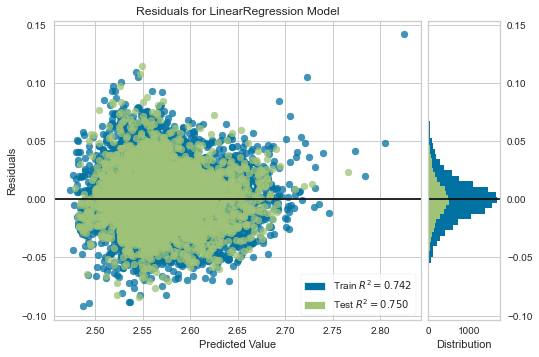

In [214]:
visualizer = ResidualsPlot(model4)

visualizer.fit(X_train4, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test4, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

The error terms from Model 4 do not seem to be violating any assumptions.

#### We create Model 4 again using Statsmodel
Again, we do this to check the significant of the predictors from the summary table

In [215]:
endog = y_train
exog = X_train4
lin_reg_model = sm.OLS(endog=endog, exog=sm.add_constant(exog)).fit()

In [216]:
lin_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     1175.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:27:15   Log-Likelihood:                 37545.
No. Observations:               15171   AIC:                        -7.501e+04
Df Residuals:                   15133   BIC:                        -7.472e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.4824      0.001   2520.829      0.000       2.481       2.484
ohe__x0_EXCELLENT         0.0271      0.001     19.544      0.000       0.024       0.030
ohe__x0_FAIR              0.0081      0.001      6.201      0.000       0.006       0.011
ohe__x0_GOOD              0.0101      0.001      9.078      0.000       0.008       0.012
ohe__x1_Fair             -0.0113      0.002     -5.934      0.000      -0.015      -0.008
ohe__x1_Good              0.0060      0.000     14.811      0.000       0.005       0.007
ohe__x1_Very Good         0.0131      0.001     20.742      0.000       0.012       0.014
ohe__x2_5                -0.0255      0.002    -16.133      0.000      -0.029      -0.022
ohe__x2_6                -0.0172      0.001    -27.696      0.000      -0.018      -0.016
ohe__x2_8                 0.0130      0.000     28.923      0.000       0.012       0.014
ohe__x2_9                 0.0258      0.001     38.274      0.000       0.025       0.027
ohe__x2_10                0.0322      0.001     32.956      0.000       0.030       0.034
ohe__x2_11                0.0360      0.002     23.107      0.000       0.033       0.039
ohe__x2_12                0.0321      0.003     11.184      0.000       0.026       0.038
ohe__x2_13                0.0331      0.007      4.683      0.000       0.019       0.047
ohe__x3_Bellevue          0.0566      0.001     61.573      0.000       0.055       0.058
ohe__x3_Black Diamond     0.0220      0.002      8.883      0.000       0.017       0.027
ohe__x3_Bothell           0.0357      0.002     19.711      0.000       0.032       0.039
ohe__x3_Carnation         0.0268      0.002     11.816      0.000       0.022       0.031
ohe__x3_Duvall            0.0288      0.002     15.318      0.000       0.025       0.033
ohe__x3_Fall City         0.0375      0.003     13.704      0.000       0.032       0.043
ohe__x3_Issaquah          0.0405      0.001     36.884      0.000       0.038       0.043
ohe__x3_Kenmore           0.0337      0.002     21.564      0.000       0.031       0.037
ohe__x3_Kent              0.0049      0.001      4.980      0.000       0.003       0.007
ohe__x3_Kirkland          0.0502      0.001     50.769      0.000       0.048       0.052
ohe__x3_Maple Valley      0.0152      0.001     12.911      0.000       0.013       0.018
ohe__x3_Medina            0.0919      0.004     24.815      0.000       0.085       0.099
ohe__x3_Mercer Island     0.0650      0.002     40.401      0.000       0.062       0.068
ohe__x3_North Bend        0.0283      0.002     16.722      0.000       0.025       0.032
ohe__x3_Redmond           0.0468      0.001     45.844      0.000       0.045       0.049
ohe__x3_Renton            0.0202      0.001     22.858      0.000       0.018       0.022
ohe__x3_Sammamish      

# Things to do- 
Check why isnt the summary table the same as the one we made in my notebook! 